# CD4+ T cell behavior in COVID-19 infection


In [20]:
# Load library and BoolNetPerturb functions
library(dplyr)
library(BoolNet)
library(alluvial)
for (f in list.files("BNP")) { source( paste('BNP/', f, sep='') ) }
# Load data
net <-  loadNetwork("data/thsocs_net.csv")
net.covmod <- loadNetwork("data/thsocs_net_covmod.csv")
net.covsev <- loadNetwork("data/thsocs_net_covsev.csv")
net.covtgfb <- loadNetwork("data/thsocs_net_covtgfb.csv")
net.socs <- c('SOCS1', 'SOCS2', 'SOCS3', 'SOCS5')
net.ext  <- c('IFNGe', 'IL12e', 'IL2e', 'IL4e', 'IL6e', 'TGFBe', 'IL10e', 'TCR')

env <- read.csv("data/thsocs_environment.csv")
lab <- read.csv("data/thsocs_label.csv")
lab.names <- c('Naive', 'Anergy', 'Th1', 'Th2', 'Th17', 'Th1R', 'Th2R', 'Tr', 'Treg')

## CD4+ T cell regulatory network and subsets
    * [/] Th network
    * [/] Th subsets color:red/yellow
    * [/] Th subsets table

### Regulatory network
![CD4+ T cell regulatory network](images/thsocs_net.png)

### Attractors

null device 
          1

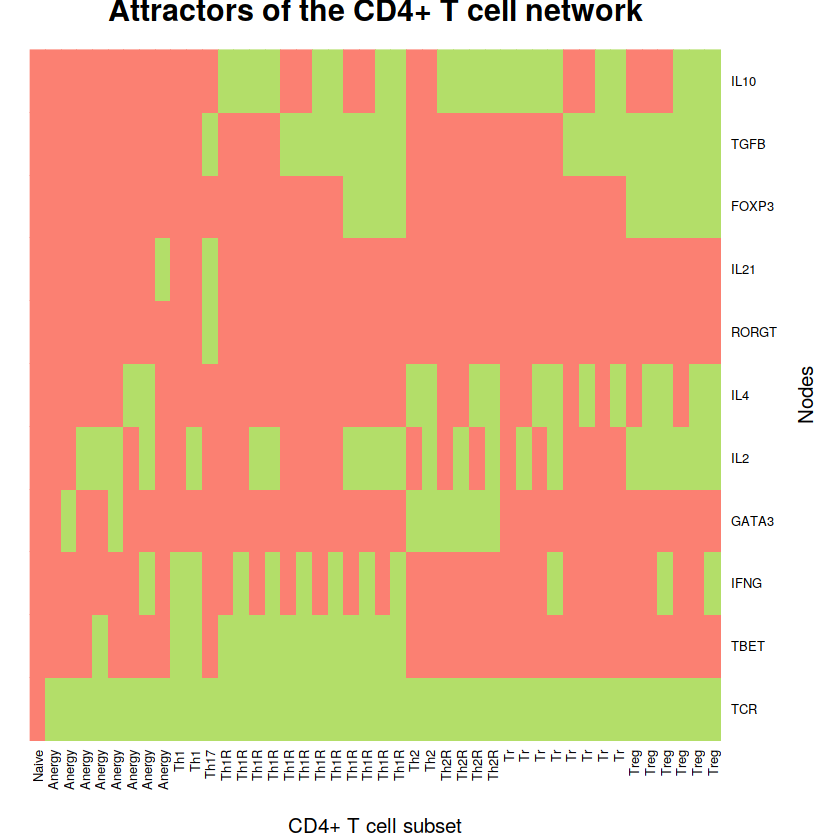

In [21]:
file.attr <- "data/thsocs_attr_WT.csv"
file.attr.pdf <- "images/thsocs_attr.pdf"

if (! file.exists(file.attr)) {
    # calculate attractors
    attr <- getAttractors(net)
    labels <- labelAttractors(attr, lab, net_$genes)
    # add subset labels
    attr.table <- attractorToDataframe(attr, Boolean=TRUE)
    attr.table$attractor <- labels
    attr.table <- attr.table[with(attr.table, order(
                             TCR, attractor, FOXP3, TGFB, IL10, 
                             IL21,RORGT,IL4,IL2,GATA3,IFNG,TBET)),]
    write.csv(attr.table,file.attr, row.names=FALSE)
} else {
    attr.table <- read.csv(file = file.attr)
}

# select key nodes for plotting
attr.table <- subset(attr.table, select = c("attractor","TCR", 
                                            "TBET","IFNG","GATA3","IL2","IL4",
                                            "RORGT","IL21","FOXP3","TGFB","IL10") )
attr.table <- unique(attr.table)

if (! file.exists(file.attr.pdf)) { pdf(file.attr.pdf) }
heatmap(t(as.matrix( subset(attr.table, select=-attractor ))),
        labCol=attr.table$attractor,
        main="Attractors of the CD4+ T cell network", 
        xlab="CD4+ T cell subset", ylab="Nodes",
        col=c('#fb8072','#b3de69'), cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
       )
dev.off()

## Effect of the environment in CD4+ T cell differentiation during COVID-19
    * [/] Cytokines
    * [/] Celltype by env table
    * [/] Celltype by env color:brown
    
### Environments

In [22]:
# plot environments
env

,IFNGe,IL12e,IL2e,IL4e,IL6e,TGFBe,IL10e
Basal,0,0,0,0,0,0,0
pro-Th1,1,1,0,0,0,0,0
pro-Th2,0,0,1,1,0,0,0
pro-Th17,0,0,0,0,1,1,0
pro-Treg,0,0,1,0,0,1,0
Pro-Tr,0,0,0,0,0,1,1
CoV-mod,1,1,0,0,0,0,0
CoV-sev,1,1,0,1,1,0,0
CoV-sev-TGFB,1,1,0,1,1,1,0


### Basin size by environment

* CoV-mod has the same signature as Th1
* CoV-mod and CoV-sev have similar presence of celltypes:
    * Anergy, Th1, Th1R, Th2R, Tr
* In CoV-sev the anergy basin is 4 times biger, while the Th1 basin is half, with little change in regulatory cell types
* If there is TGFB in CoV-sev we have Th17, Th1R and Tr with no Treg or Th1
    * possible worst outcome, activation of innate inflamation, no adaptive citotoxicity, also fibrosis
    * check TGFB in patients, while it may have regulatory effects it may induce Th17

In [23]:
file.env.attr <- "data/thsocs_env_attr.csv"

if (! file.exists(file.env.attr)) {
    env.attr <- perturbNetworkFixedNodes(net, label.rules=lab, returnDataFrame='basinSize',
                              genes  = rep( list(colnames(env)), times=nrow(env) ),
                              values = lapply( split(env,seq_along(env[,1])), as.list),
                              names  = rownames(env))
    env.attr <- env.attr[lab.names,]
    env.attr[env.attr == 0] <- NA
    write.csv(env.attr,file.env.attr)
} else {
    env.attr <- read.csv(file = file.env.attr, row.names=1)
}
env.attr

,Basal,pro.Th1,pro.Th2,pro.Th17,pro.Treg,Pro.Tr,CoV.mod,CoV.sev,CoV.sev.TGFB
Naive,16384,16384,16384,16384,16384,16384,16384,16384,16384
Anergy,8670,1232,804,NA,NA,NA,1232,5264,NA
Th1,940,6280,272,NA,NA,NA,6280,3936,NA
Th2,454,NA,8988,NA,NA,NA,NA,NA,NA
Th17,NA,NA,NA,8704,156,NA,NA,NA,3456
Th1R,2088,7992,264,1088,2672,2672,7992,6352,10288
Th2R,112,88,112,NA,NA,NA,88,80,NA
Tr,4120,792,1192,6592,2110,13712,792,752,2640
Treg,NA,NA,4752,NA,11446,NA,NA,NA,NA


null device 
          1

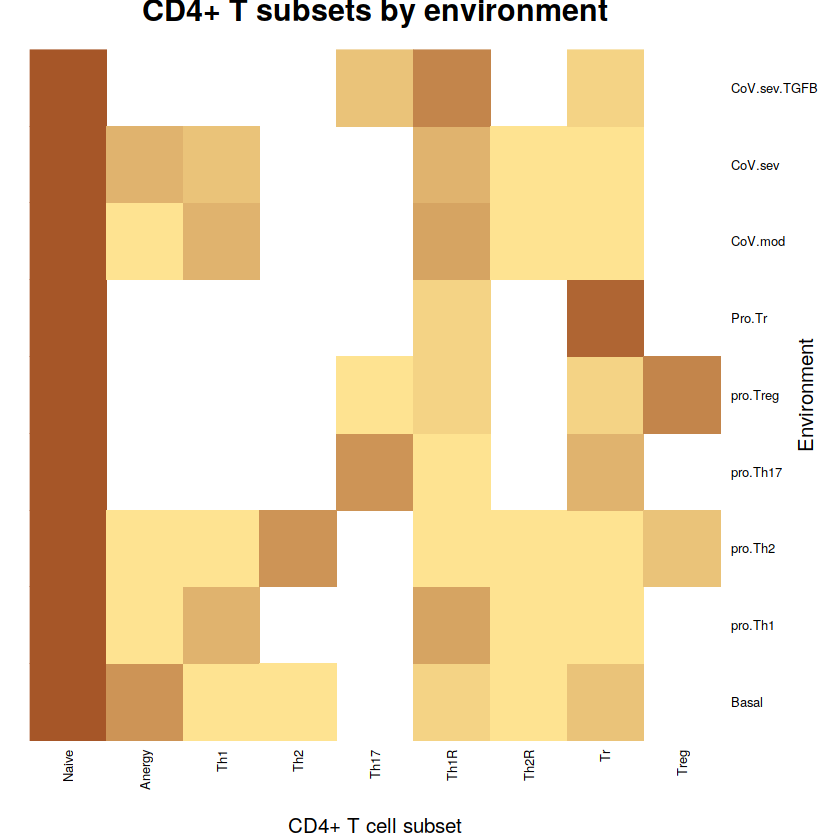

In [5]:
file.env.attr.pdf <- "images/thsocs_env_attr.pdf"
presence = F

if (presence) {
    env.attr <- env.attr/env.attr
    color = '#a65628'
} else { 
    colfunc <- colorRampPalette(c('#fee391', '#a65628'))
    color <- colfunc(10)
}

if (! file.exists(file.env.attr.pdf)) { pdf(file.env.attr.pdf) }
heatmap(t(as.matrix( subset(env.attr ))),
        main="CD4+ T subsets by environment", 
        xlab="CD4+ T cell subset", ylab="Environment",
        col=color, cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
       )
dev.off()

png 
  3

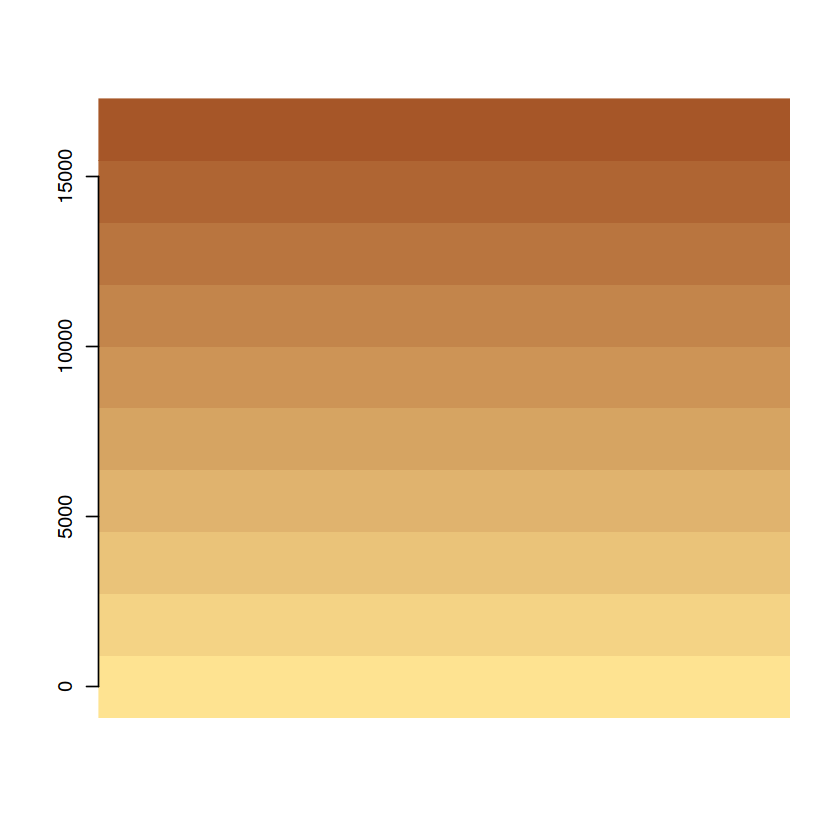

In [56]:
file.env.attr.colscale.pdf <- "images/thsocs_env_attr_colscale.pdf"

if (! file.exists(file.env.attr.colscale.pdf)) { pdf(file.env.attr.pdf) }
y=seq(1, max(env.attr, na.rm=T), length.out=length(color))
image(1,col_seq,matrix(1:length(color),nrow=1),
      col=color,axes=FALSE,xlab="",ylab="")
axis(2)
dev.off()

## CD4+ T cell stability and plasticity in COVID-19
    * [/] Cell fate map table covmod and covsev 
    * [/] transitions by node color:red/yellow
    * [/] Stability by subset in covmod and covsev

In [6]:
f.cfm.table <- function(net, lab, file.name) {
    if (! file.exists(file.name)) {
        cfm <- cellFateMap(net, label.rules=lab, 
                           method="sat.restricted", maxAttractorLength=2) 
        cfm <- apply(cfm,2,as.character)
        cfm <- cfm[  order( cfm[,1], cfm[,2], cfm[,3], cfm[,4] ),]
        write.csv(cfm,file.name, row.names=F)
    } else {
        cfm <- read.csv(file = file.name)
    }
    cfm
}
cfm.covmod <- f.cfm.table(net.covmod, lab, "data/thsocs_cfm_covmod.csv")
cfm.covsev <- f.cfm.table(net.covsev, lab, "data/thsocs_cfm_covsev.csv")
cfm.covtgfb <- f.cfm.table(net.covtgfb, lab, "data/thsocs_cfm_covtgfb.csv")

### Transitions by node

Key nodes: IFNG, IL10, TGFB

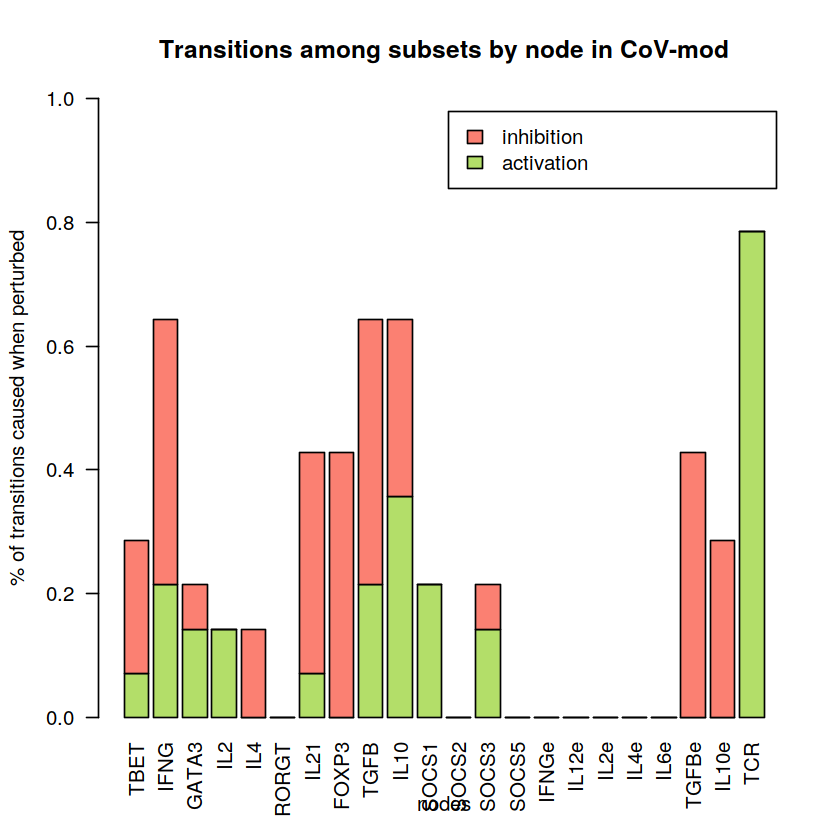

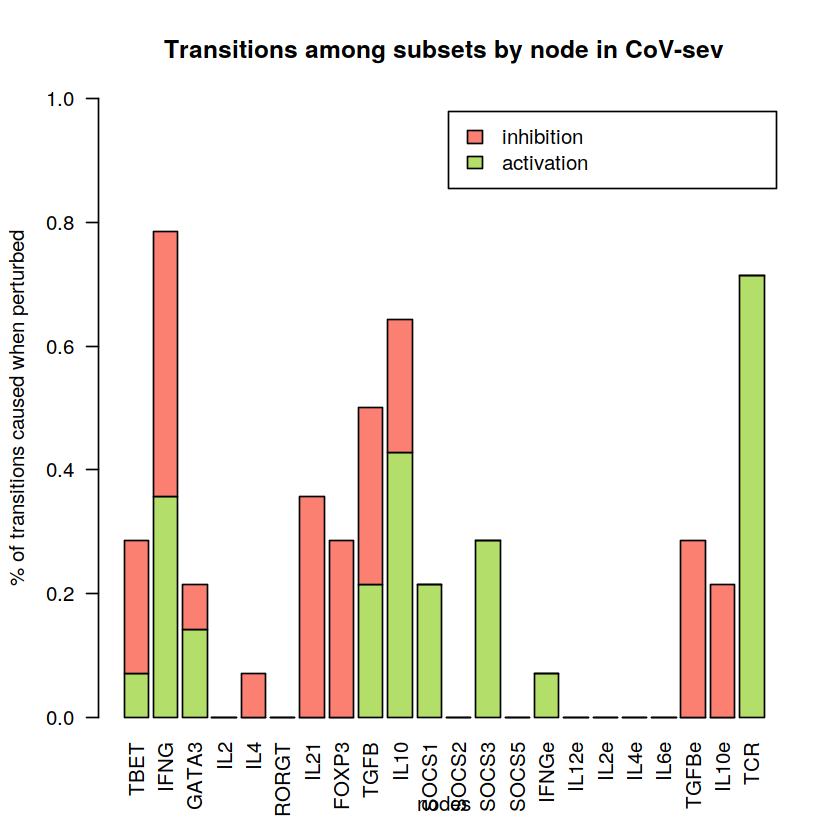

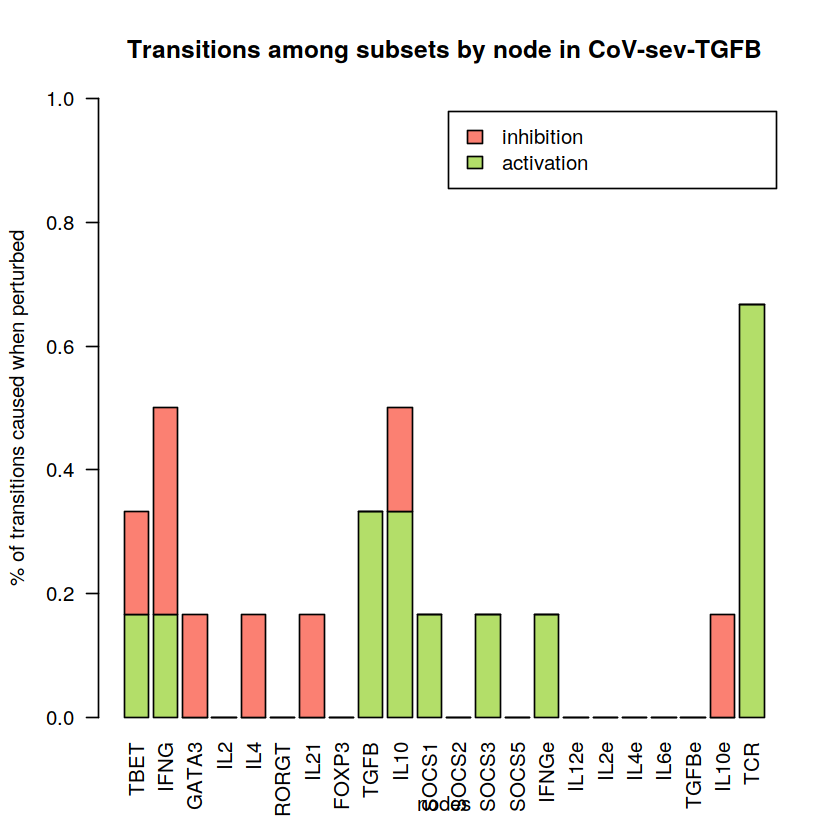

In [7]:
plot.node.transitions <- function(cfm, file.name, normalize=T, title='') {
    cfm.diff <- cfm[cfm$initial!=cfm$final,]
    node.transitions <- merge( summary(cfm.diff[cfm.diff$values==0,'genes']), 
                               summary(cfm.diff[cfm.diff$values==1,'genes']),
                               by=0, all=TRUE)
    rownames(node.transitions) <- node.transitions$Row.names
    node.transitions <- subset(node.transitions, select = -Row.names )
    colnames(node.transitions) <- c('activation','inhibition')
    node.transitions <- node.transitions[net$genes,]
    if (normalize) { node.transitions <- node.transitions/summary(cfm$genes) }
    node.transitions
    
    if (! file.exists(file.name)) { 
        pdf(file.name) 
        save.pdf <- T
    } else { 
        save.pdf <- F
    }
    barplot(t(as.matrix( node.transitions )),
            main=title, xlab='nodes', ylab='% of transitions caused when perturbed',
            col=c('#b3de69','#fb8072'), ylim=c(0,1), las=2, legend=T,
           )
    if (save.pdf) { dev.off() }
}

plot.node.transitions(cfm.covmod, 'images/thsocs_transitionnode_covmod.pdf', 
                      title='Transitions among subsets by node in CoV-mod')
plot.node.transitions(cfm.covsev, 'images/thsocs_transitionnode_covsev.pdf',
                      title='Transitions among subsets by node in CoV-sev')
plot.node.transitions(cfm.covtgfb, 'images/thsocs_transitionnode_covtgfb.pdf',
                      title='Transitions among subsets by node in CoV-sev-TGFB')

### Stability by celltype

* CoV-mod, Th1 > Anergy both in basin size, stablity, and transitions towards
* CoV-sev, Th1 < Anergy both in basin size, stablity, and transitions towards
* Cov-TGFB, no anergy nor Th1, presence of Th17 and transitions towards
* Discuss roles of local microenvironment

[1] "Transitions between cell types in CoV-mod"
# A tibble: 19 x 3
# Groups:   initial [5]
   initial final   freq
   <fct>   <fct>  <int>
 1 Anergy  Anergy    42
 2 Anergy  Th1       16
 3 Anergy  Th1R       6
 4 Anergy  Th2R       2
 5 Th1     Anergy     1
 6 Th1     Th1       33
 7 Th1     Th1R      10
 8 Th1R    Anergy     1
 9 Th1R    Th1       12
10 Th1R    Th1R      94
11 Th1R    Tr         3
12 Th2R    Anergy     4
13 Th2R    Th1        6
14 Th2R    Th1R       3
15 Th2R    Th2R      25
16 Th2R    Tr         6
17 Tr      Th1        3
18 Tr      Th1R       4
19 Tr      Tr        15


Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

[1] "Transitions between cell types in CoV-sev"
# A tibble: 17 x 3
# Groups:   initial [5]
   initial final   freq
   <fct>   <fct>  <int>
 1 Anergy  Anergy    58
 2 Anergy  Th1        6
 3 Anergy  Th2R       2
 4 Th1     Anergy     4
 5 Th1     Th1       30
 6 Th1     Th1R      10
 7 Th1R    Anergy    13
 8 Th1R    Th1        5
 9 Th1R    Th1R      89
10 Th1R    Tr         3
11 Th2R    Anergy    11
12 Th2R    Th1R       2
13 Th2R    Th2R      25
14 Th2R    Tr         6
15 Tr      Anergy     5
16 Tr      Th1R       2
17 Tr      Tr        15


Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

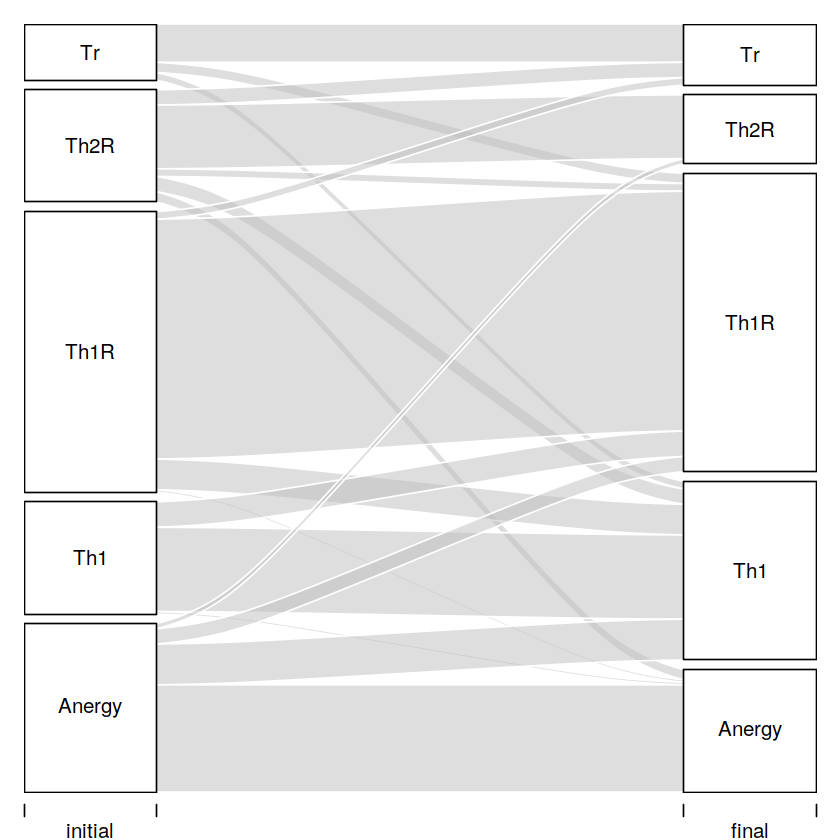

[1] "Transitions between cell types in CoV-sev-TGFB"
# A tibble: 9 x 3
# Groups:   initial [3]
  initial final  freq
  <fct>   <fct> <int>
1 Th17    Th17     18
2 Th17    Th1R      2
3 Th17    Tr        2
4 Th1R    Th17      7
5 Th1R    Th1R     54
6 Th1R    Tr        5
7 Tr      Th17      3
8 Tr      Th1R      2
9 Tr      Tr       17


Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

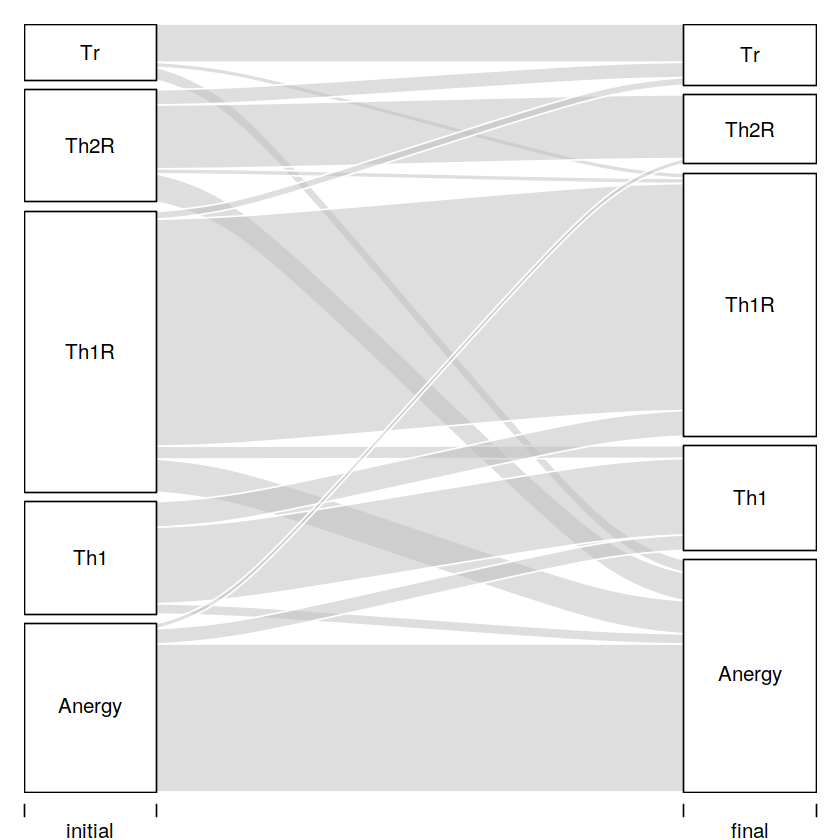

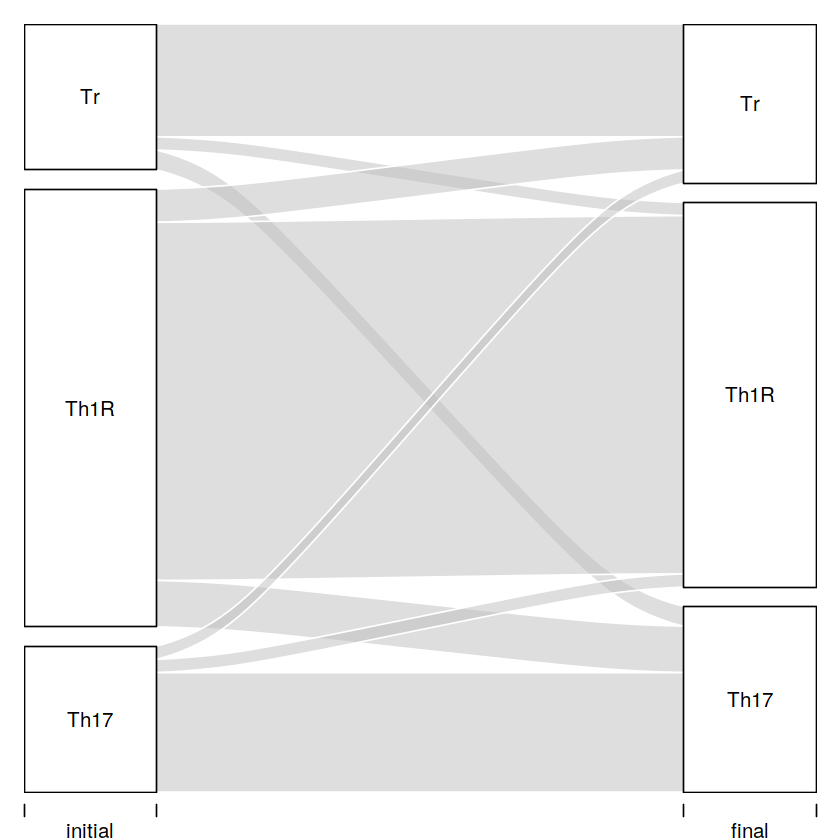

In [10]:
plot.cfm.alluvial <- function(cfm, file.name, title='', ignore='Naive') {
    if (! file.exists(file.name)) { 
        pdf(file.name) 
        save.pdf=T
    } else { 
        save.pdf <- F
    }
    cfm <- cfm[cfm$initial!=ignore,]
    cfm %>% group_by(initial, final) %>%
            summarize(freq = n()) -> cfm2d
    print(title)
    print(cfm2d)
    alluvial(cfm2d[,1:2], freq=cfm2d$freq)
    if (save.pdf) { dev.off() }
    }

plot.cfm.alluvial(cfm.covmod, 'images/thsocs_alluvial_covmod.pdf',
                  title='Transitions between cell types in CoV-mod')
plot.cfm.alluvial(cfm.covsev, 'images/thsocs_alluvial_covsev.pdf',
                  title='Transitions between cell types in CoV-sev')
plot.cfm.alluvial(cfm.covtgfb, 'images/thsocs_alluvial_covtgfb.pdf',
                  title='Transitions between cell types in CoV-sev-TGFB')

### Interventions and secondary effects
* IFNG_1: small effect, may activate some anergic->Th1, in CoV-TGFB may change Th17->Th1R
* IL21_1: no, secondary effects are strong inflamation/anergy
* IL10_0: no, some Th1R->Th1 but also induces anergy, in CoV-TGFB may change Th1R->Th17 
* TGFB_0: cautiously, good in CoV-Mod, small in CoV-Sev, may induce Th17 in CoV-TGFB so neccesary sustained treatment, see mutants to avoid CoV-TGFB, 
* SOCS_1: yes, increases Th1 with little secondary effects, see mutants, it increases Th1-basin, small effec in Th17-Th1R in CoV-TGFB
* SOCS_3: small effect, may induce anergy



In [11]:
cfm <- cfm.covmod
diff <- cfm[cfm$initial!=cfm$final,]
diff <- diff[diff$final=='Th1',]
print('Interventions')
diff
print('Secondary effects')
cfm[cfm$genes=='IFNG' & cfm$values==1,]
cfm[cfm$genes=='IL21' & cfm$values==1,]
cfm[cfm$genes=='IL10' & cfm$values==0,]
cfm[cfm$genes=='TGFB' & cfm$values==0,]
cfm[cfm$genes=='SOCS1' & cfm$values==0,]
cfm[cfm$genes=='SOCS3' & cfm$values==0,]


[1] "Interventions"


,initial,final,genes,values
43,Anergy,Th1,IFNG,1
44,Anergy,Th1,IFNG,1
45,Anergy,Th1,IFNG,1
46,Anergy,Th1,IL10,1
47,Anergy,Th1,IL10e,1
48,Anergy,Th1,IL2,0
49,Anergy,Th1,IL2,0
50,Anergy,Th1,IL21,0
51,Anergy,Th1,IL4,1
52,Anergy,Th1,SOCS1,0


[1] "Secondary effects"


,initial,final,genes,values
43,Anergy,Th1,IFNG,1
44,Anergy,Th1,IFNG,1
45,Anergy,Th1,IFNG,1
69,Naive,Naive,IFNG,1
157,Th1R,Th1R,IFNG,1
253,Th2R,Th1R,IFNG,1
254,Th2R,Th1R,IFNG,1
290,Tr,Th1R,IFNG,1


,initial,final,genes,values
14,Anergy,Anergy,IL21,1
15,Anergy,Anergy,IL21,1
75,Naive,Naive,IL21,1
99,Th1,Th1,IL21,1
100,Th1,Th1,IL21,1
137,Th1R,Th1,IL21,1
138,Th1R,Th1,IL21,1
181,Th1R,Th1R,IL21,1
182,Th1R,Th1R,IL21,1
183,Th1R,Th1R,IL21,1


,initial,final,genes,values
135,Th1R,Th1,IL10,0
136,Th1R,Th1,IL10,0
163,Th1R,Th1R,IL10,0
164,Th1R,Th1R,IL10,0
244,Th2R,Anergy,IL10,0
248,Th2R,Th1,IL10,0
291,Tr,Th1R,IL10,0


,initial,final,genes,values
144,Th1R,Th1,TGFB,0
145,Th1R,Th1,TGFB,0
232,Th1R,Th1R,TGFB,0
289,Tr,Th1,TGFB,0


,initial,final,genes,values
52,Anergy,Th1,SOCS1,0
53,Anergy,Th1,SOCS1,0
54,Anergy,Th1,SOCS1,0
111,Th1,Th1,SOCS1,0
112,Th1,Th1,SOCS1,0
208,Th1R,Th1R,SOCS1,0
209,Th1R,Th1R,SOCS1,0
210,Th1R,Th1R,SOCS1,0
211,Th1R,Th1R,SOCS1,0
274,Th2R,Th2R,SOCS1,0


,initial,final,genes,values
115,Th1,Th1,SOCS3,0
116,Th1,Th1,SOCS3,0
218,Th1R,Th1R,SOCS3,0
219,Th1R,Th1R,SOCS3,0
220,Th1R,Th1R,SOCS3,0
221,Th1R,Th1R,SOCS3,0
222,Th1R,Th1R,SOCS3,0
255,Th2R,Th1R,SOCS3,0
278,Th2R,Th2R,SOCS3,0
292,Tr,Th1R,SOCS3,0


In [12]:
cfm <- cfm.covsev
diff <- cfm[cfm$initial!=cfm$final,]
diff <- diff[diff$final=='Th1',]
print('Interventions')
diff
print('Secondary effects')
cfm[cfm$genes=='IFNG' & cfm$values==1,]
cfm[cfm$genes=='IL21' & cfm$values==1,]
cfm[cfm$genes=='IL10' & cfm$values==0,]
cfm[cfm$genes=='TGFB' & cfm$values==0,]
cfm[cfm$genes=='SOCS1' & cfm$values==0,]
cfm[cfm$genes=='SOCS3' & cfm$values==0,]


[1] "Interventions"


,initial,final,genes,values
59,Anergy,Th1,IFNG,1
60,Anergy,Th1,IFNG,1
61,Anergy,Th1,IFNG,1
62,Anergy,Th1,SOCS1,0
63,Anergy,Th1,SOCS1,0
64,Anergy,Th1,SOCS1,0
146,Th1R,Th1,IL10,0
147,Th1R,Th1,IL10,0
148,Th1R,Th1,IL21,1
149,Th1R,Th1,SOCS3,0


[1] "Secondary effects"


,initial,final,genes,values
59,Anergy,Th1,IFNG,1
60,Anergy,Th1,IFNG,1
61,Anergy,Th1,IFNG,1
69,Naive,Naive,IFNG,1
161,Th1R,Th1R,IFNG,1
254,Th2R,Th1R,IFNG,1
255,Th2R,Th1R,IFNG,1
292,Tr,Th1R,IFNG,1


,initial,final,genes,values
21,Anergy,Anergy,IL21,1
22,Anergy,Anergy,IL21,1
75,Naive,Naive,IL21,1
101,Th1,Th1,IL21,1
102,Th1,Th1,IL21,1
138,Th1R,Anergy,IL21,1
148,Th1R,Th1,IL21,1
183,Th1R,Th1R,IL21,1
184,Th1R,Th1R,IL21,1
185,Th1R,Th1R,IL21,1


,initial,final,genes,values
137,Th1R,Anergy,IL10,0
146,Th1R,Th1,IL10,0
147,Th1R,Th1,IL10,0
166,Th1R,Th1R,IL10,0
245,Th2R,Anergy,IL10,0
246,Th2R,Anergy,IL10,0
287,Tr,Anergy,IL10,0


,initial,final,genes,values
145,Th1R,Anergy,TGFB,0
150,Th1R,Th1,TGFB,0
232,Th1R,Th1R,TGFB,0
291,Tr,Anergy,TGFB,0


,initial,final,genes,values
62,Anergy,Th1,SOCS1,0
63,Anergy,Th1,SOCS1,0
64,Anergy,Th1,SOCS1,0
81,Naive,Naive,SOCS1,0
113,Th1,Th1,SOCS1,0
114,Th1,Th1,SOCS1,0
210,Th1R,Th1R,SOCS1,0
211,Th1R,Th1R,SOCS1,0
212,Th1R,Th1R,SOCS1,0
213,Th1R,Th1R,SOCS1,0


,initial,final,genes,values
117,Th1,Th1,SOCS3,0
118,Th1,Th1,SOCS3,0
139,Th1R,Anergy,SOCS3,0
149,Th1R,Th1,SOCS3,0
220,Th1R,Th1R,SOCS3,0
221,Th1R,Th1R,SOCS3,0
222,Th1R,Th1R,SOCS3,0
249,Th2R,Anergy,SOCS3,0
278,Th2R,Th2R,SOCS3,0
289,Tr,Anergy,SOCS3,0


In [13]:
cfm <- cfm.covtgfb
diff <- cfm[cfm$initial!=cfm$final,]
diff <- diff[diff$final=='Th1',]
print('Interventions')
diff
print('Secondary effects')
cfm[cfm$genes=='IFNG' & cfm$values==1,]
cfm[cfm$genes=='IL21' & cfm$values==1,]
cfm[cfm$genes=='IL10' & cfm$values==0,]
cfm[cfm$genes=='TGFB' & cfm$values==0,]
cfm[cfm$genes=='SOCS1' & cfm$values==0,]
cfm[cfm$genes=='SOCS3' & cfm$values==0,]


[1] "Interventions"


initial,final,genes,values


[1] "Secondary effects"


,initial,final,genes,values
3,Naive,Naive,IFNG,1
41,Th17,Th1R,IFNG,1
58,Th1R,Th1R,IFNG,1
114,Tr,Th1R,IFNG,1


,initial,final,genes,values
9,Naive,Naive,IL21,1
72,Th1R,Th1R,IL21,1
73,Th1R,Th1R,IL21,1
107,Th1R,Tr,IL21,1
122,Tr,Tr,IL21,1


,initial,final,genes,values
47,Th1R,Th17,IL10,0
61,Th1R,Th1R,IL10,0
111,Tr,Th17,IL10,0


,initial,final,genes,values
39,Th17,Th17,TGFB,0
51,Th1R,Th17,TGFB,0
101,Th1R,Th1R,TGFB,0
102,Th1R,Th1R,TGFB,0
113,Tr,Th17,TGFB,0


,initial,final,genes,values
15,Naive,Naive,SOCS1,0
42,Th17,Th1R,SOCS1,0
88,Th1R,Th1R,SOCS1,0
89,Th1R,Th1R,SOCS1,0
90,Th1R,Th1R,SOCS1,0
128,Tr,Tr,SOCS1,0


,initial,final,genes,values
94,Th1R,Th1R,SOCS3,0
95,Th1R,Th1R,SOCS3,0
109,Th1R,Tr,SOCS3,0
130,Tr,Tr,SOCS3,0


## CD4+ T cell KO and overexpression mutants in COVID-19
    * [/] Mutants in WT, covmod, and covsev table
    * [/] Mutants in WT, covmod, and covsev scale:purple
    * [/] Compare covmod vs covsev

In [14]:
f.mut.table <- function(net, lab, file.name) {
    if (! file.exists(file.name)) {
        mutants <- perturbNetworkFixedNodes(net, label.rules=lab, returnDataFrame='basinSize')
        mut_socs <- perturbNetworkFixedNodes(net, label.rules=lab, returnDataFrame='basinSize',
                                         genes  = list(c('SOCS1','SOCS2','SOCS3','SOCS5'),c('SOCS1','SOCS2','SOCS3','SOCS5')),
                                         values = list(0,1),
                                         names  = c('SOCSall_0','SOCSall_1'))
        mutants <- merge(mutants, mut_socs, by=0, all=TRUE)
        rownames(mutants) <- mutants$Row.names
        mutants[mutants == 0] <- NA
        write.csv(mutants,file.name)
    } else {
        mutants <- read.csv(file = file.name, row.names=1)
    }
    mutants
}

f.mut.plot <- function(mutants, file.name, save.pdf=FALSE, normalize=T) {
    if (save.pdf) { pdf(image.name) }
    if (normalize) {
        mutants <- mutants/mutants
        color <- c('#bebada')
    } else {
        colfunc <- colorRampPalette(c('#bfd3e6', '#810f7c'))
        color <- colfunc(10)
    }
    
    heatmap(t(as.matrix( mutants )),
            main="CD4+ T subsets mutants", 
            xlab="CD4+ T cell subset", ylab="Mutant",
            col=color, cexCol=0.75, cexRow=0.75,
            Colv = NA, Rowv = NA, scale="none",
           )
    if (save.pdf) {dev.off() }
}

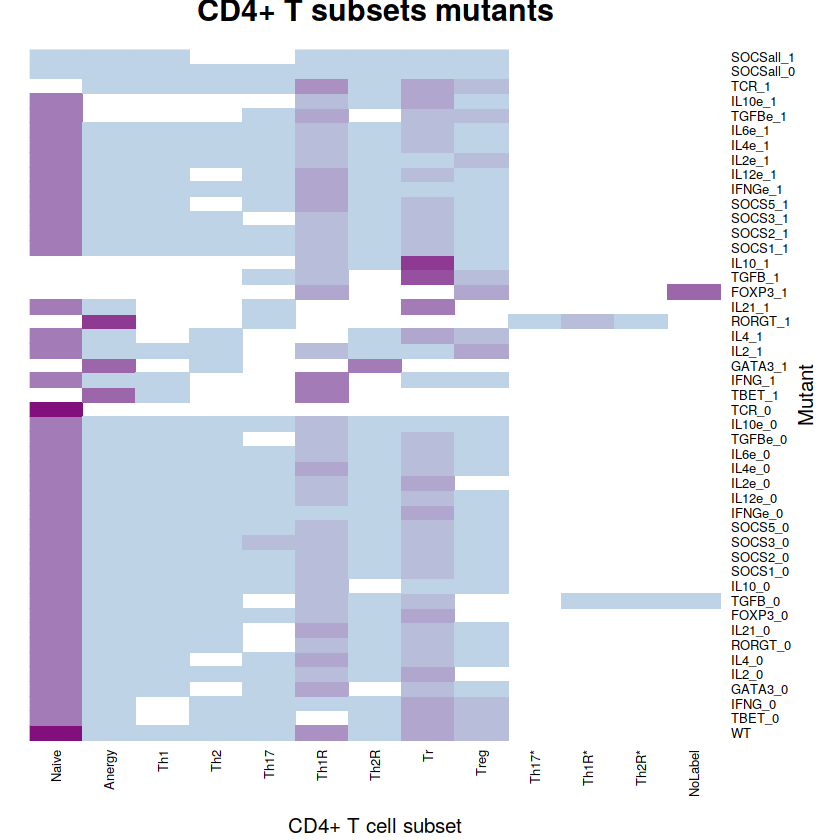

In [15]:
f.mut <- f.mut.table(net, lab, "data/thsocs_mut_wt.csv")
f.mut.plot(f.mut, "images/thsocs_mut_wt.pdf", normalize=F)

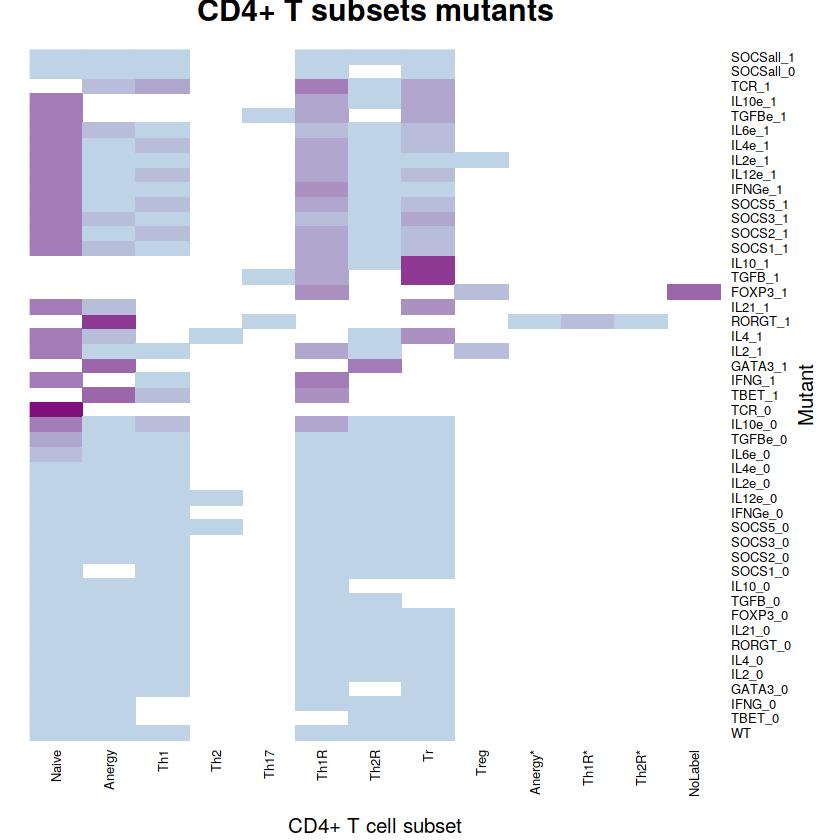

In [16]:
f.mut.covmod <- f.mut.table(net.covmod, lab, "data/thsocs_mut_covmod.csv")
f.mut.plot(f.mut.covmod, "images/thsocs_mut_covmod.pdf", normalize=F)

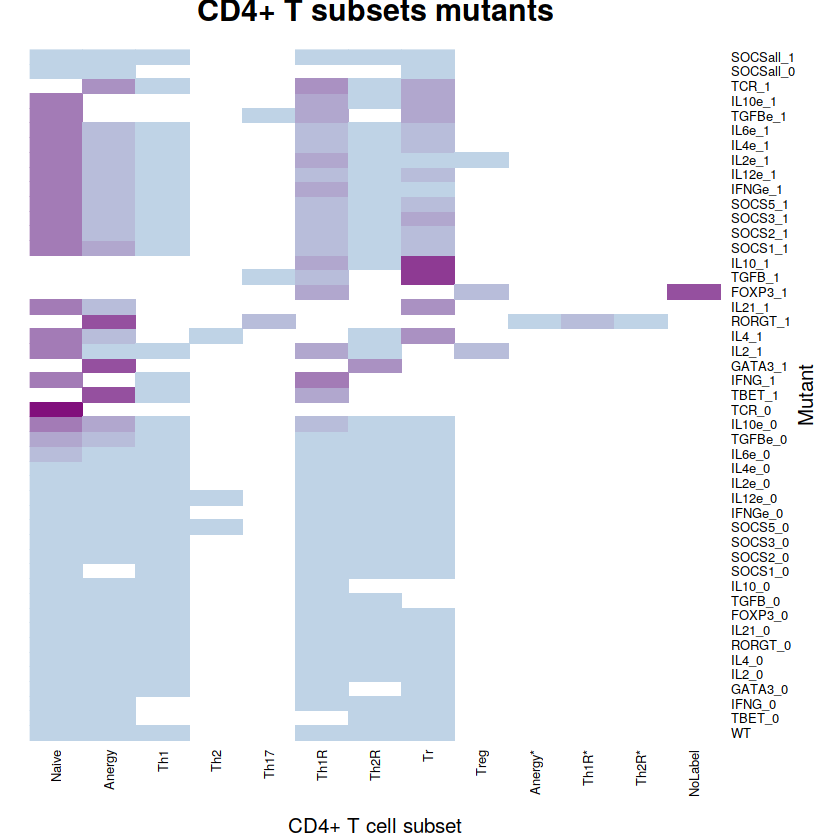

In [17]:
f.mut.covsev <- f.mut.table(net.covsev, lab, "data/thsocs_mut_covsev.csv")
f.mut.plot(f.mut.covsev, "images/thsocs_mut_covsev.pdf", normalize=F)

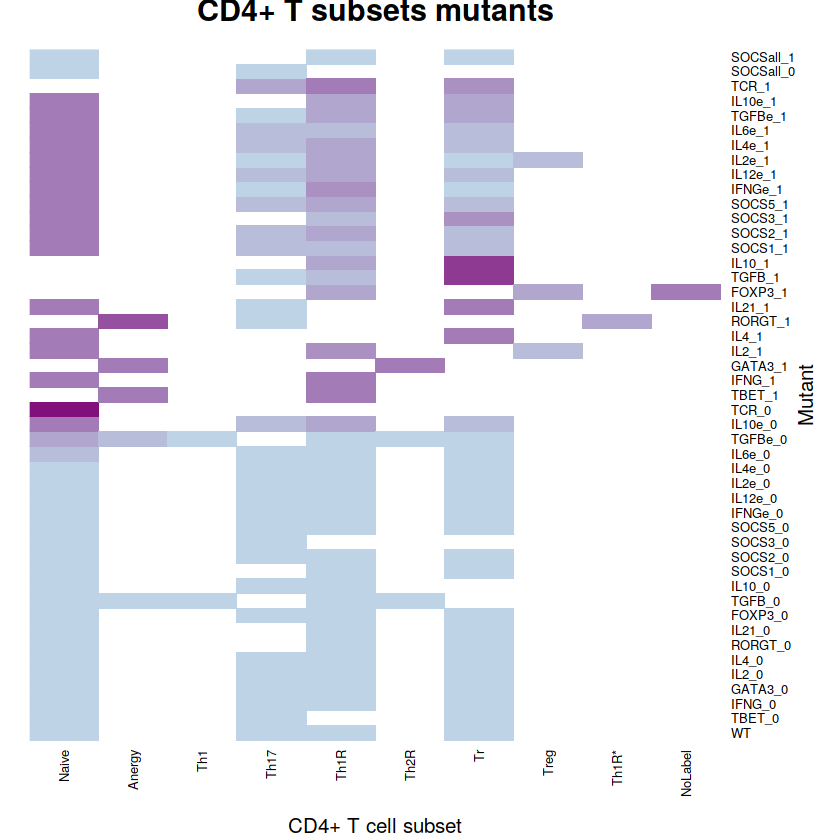

In [18]:
f.mut.covtgfb <- f.mut.table(net.covtgfb, lab, "data/thsocs_mut_covtgfb.csv")
f.mut.plot(f.mut.covtgfb, "images/thsocs_mut_covtgfb.pdf", normalize=F)

### CoV-mod vs CoV-sev

Warning message in image.default(1L:nc, 1L:nr, x, xlim = 0.5 + c(0, nc), ylim = 0.5 + :
“unsorted 'breaks' will be sorted before use”

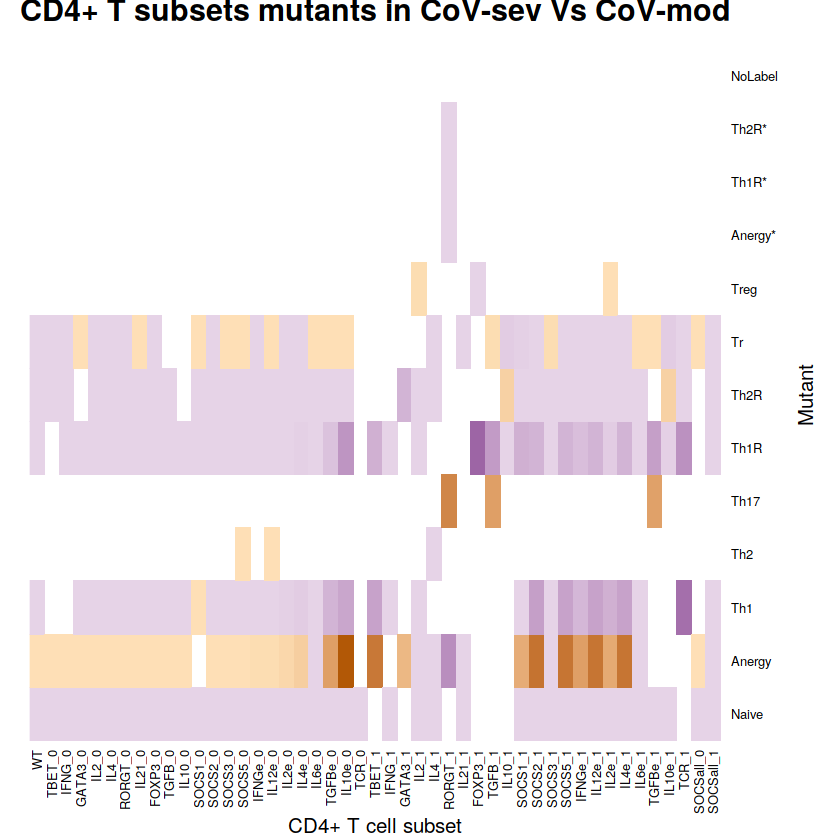

In [19]:
file.name <- 'images/thsocs_mut_covmodvssev.pdf'
save.pdf <- F

diff <- as.matrix(f.mut.covsev-f.mut.covmod)
Min <- -min(diff, na.rm = T)
Max <- -max(diff, na.rm = T)
Thresh <- 0

rc1 <- colorRampPalette(colors = c("#762a83", "#e7d4e8"), space="Lab")(50)    
rc2 <- colorRampPalette(colors = c("#fee0b6", "#b35806"), space="Lab")(50)
rampcols <- c(rc1, rc2)
rb1 <- seq(Min, Thresh, length.out=51)
rb2 <- seq(Thresh, Max, length.out=51)[-1]
rampbreaks <- c(rb1, rb2)

if (save.pdf) { pdf(file.name) }
heatmap(diff, Rowv = NA, Colv = NA, scale="none",
        main="CD4+ T subsets mutants in CoV-sev Vs CoV-mod", 
        xlab="CD4+ T cell subset", ylab="Mutant",
        cexCol=0.75, cexRow=0.75,
        col = rampcols, breaks = rampbreaks)
if (save.pdf) {dev.off() }

Done